# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
utah  = df.loc[df.State == 'UT']
len(utah.RegionName) # 121 unique zipcodes

121

In [4]:
len(utah.CountyName.unique()) # 21 counties present in dataset

21

In [5]:
utah.CountyName.unique()
# high pop counties = Salt Lake, Utah, Davis, Weber, Washington, Cashe, Tooele, Box Elder, Iron, Summit

array(['Weber', 'Davis', 'Utah', 'Salt Lake', 'Washington', 'Tooele',
       'Cache', 'Uintah', 'Box Elder', 'Summit', 'Iron', 'Wasatch',
       'Carbon', 'Duchesne', 'Morgan', 'Sevier', 'Kane', 'Juab',
       'Sanpete', 'San Juan', 'Garfield'], dtype=object)

In [6]:
#filtering for top 10 most populated counties. 90% of Utah population lives in these counties
utah = utah.loc[(utah['CountyName']== 'Salt Lake') |(utah['CountyName']== 'Utah')|(utah['CountyName']== 'Davis')|(utah['CountyName']== 'Weber')|(utah['CountyName']== 'Washington')|(utah['CountyName']== 'Cache')|(utah['CountyName']== 'Tooele')|(utah['CountyName']== 'Box Elder')|(utah['CountyName']== 'Iron')|(utah['CountyName']== 'Summit')]

In [7]:
len(utah.RegionName) # 102 zipcodes

102

In [8]:
utah

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
525,94562,84404,Ogden,UT,Ogden,Weber,526,107200.0,108200.0,109100.0,...,202900,204000,205300,206500,207800,209200,210700,213400,217000,219600
637,94384,84015,Clearfield,UT,Ogden,Davis,638,120600.0,121200.0,121800.0,...,217500,220400,222300,223900,226200,229000,230800,234900,239600,241500
1088,94410,84043,Lehi,UT,Provo,Utah,1089,174300.0,174800.0,175000.0,...,336200,338900,339700,340000,341900,344700,347300,349200,351900,354900
1231,94408,84041,Layton,UT,Ogden,Davis,1232,130500.0,131000.0,131500.0,...,235100,236000,236800,238600,241000,243900,246200,250700,255200,256300
1419,94479,84119,West Valley City,UT,Salt Lake City,Salt Lake,1420,118300.0,118200.0,118300.0,...,236800,242100,246900,249800,251900,254100,256000,258600,261400,262700
1495,94715,84790,Saint George,UT,St. George,Washington,1496,143300.0,143700.0,144100.0,...,269800,273000,275700,278500,281800,283900,284700,287700,293000,297300
1555,94702,84770,Saint George,UT,St. George,Washington,1556,132000.0,132100.0,132300.0,...,243300,246000,248000,249600,251600,253700,255000,257000,259900,261800
1579,94439,84074,Tooele,UT,Salt Lake City,Tooele,1580,106900.0,107700.0,108600.0,...,212300,216500,220100,223600,227700,232000,235500,237700,238300,237800
1600,94481,84121,Cottonwood Heights,UT,Salt Lake City,Salt Lake,1601,205400.0,204500.0,203500.0,...,401300,403000,403900,405400,408400,410700,411600,412900,416600,419600
1662,94380,84010,Bountiful,UT,Ogden,Davis,1663,162500.0,163600.0,164500.0,...,296800,300100,302500,303500,305000,306600,307500,310900,315600,317500


# Step 2: Data Preprocessing

In [10]:
#dropping unnecessary colums
to_drop = ['RegionID','RegionName','City','State','Metro','CountyName','SizeRank']
utah_simple = utah.drop(to_drop, axis=1)

utah_df = utah_simple.T


In [11]:
#utah_df.rename(columns={525:'zip',637:'zip2'},inplace=True)
#this renames the column
#I will now create a dictionary, which has the index number as the key and relevant zipcode as value

zipcode_dict = dict(pd.Series(utah.RegionName))
utah_df.rename(columns=zipcode_dict,inplace=True)

In [12]:
utah_df.head()

,84404,84015,84043,84041,84119,84790,84770,84074,84121,84010,...,84312,84340,84333,84320,84325,84326,84757,84774,84328,84781
1996-04,107200.0,120600.0,174300.0,130500.0,118300.0,143300.0,132000.0,106900.0,205400.0,162500.0,...,107100.0,145800.0,145200.0,132000.0,155500.0,159700.0,168400.0,141600.0,182100.0,135900.0
1996-05,108200.0,121200.0,174800.0,131000.0,118200.0,143700.0,132100.0,107700.0,204500.0,163600.0,...,107800.0,146700.0,144200.0,131300.0,156600.0,159400.0,169600.0,142200.0,182400.0,136300.0
1996-06,109100.0,121800.0,175000.0,131500.0,118300.0,144100.0,132300.0,108600.0,203500.0,164500.0,...,108500.0,147600.0,143300.0,130800.0,157600.0,159000.0,170800.0,142800.0,182600.0,136600.0
1996-07,109900.0,122500.0,175000.0,132000.0,118400.0,144500.0,132400.0,109500.0,202600.0,165100.0,...,109200.0,148500.0,142400.0,130300.0,158700.0,158700.0,171900.0,143400.0,182700.0,136900.0
1996-08,110700.0,123100.0,174600.0,132500.0,118600.0,145000.0,132500.0,110400.0,201800.0,165600.0,...,109800.0,149300.0,141500.0,129800.0,159700.0,158200.0,173000.0,144100.0,182700.0,137100.0


In [13]:
#making sure index is DatetimeIn

def get_datetimes(df):
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

times =get_datetimes(utah)
utah_df.set_index(times, inplace=True)

In [14]:
utah_df.head()

,84404,84015,84043,84041,84119,84790,84770,84074,84121,84010,...,84312,84340,84333,84320,84325,84326,84757,84774,84328,84781
1996-04-01,107200.0,120600.0,174300.0,130500.0,118300.0,143300.0,132000.0,106900.0,205400.0,162500.0,...,107100.0,145800.0,145200.0,132000.0,155500.0,159700.0,168400.0,141600.0,182100.0,135900.0
1996-05-01,108200.0,121200.0,174800.0,131000.0,118200.0,143700.0,132100.0,107700.0,204500.0,163600.0,...,107800.0,146700.0,144200.0,131300.0,156600.0,159400.0,169600.0,142200.0,182400.0,136300.0
1996-06-01,109100.0,121800.0,175000.0,131500.0,118300.0,144100.0,132300.0,108600.0,203500.0,164500.0,...,108500.0,147600.0,143300.0,130800.0,157600.0,159000.0,170800.0,142800.0,182600.0,136600.0
1996-07-01,109900.0,122500.0,175000.0,132000.0,118400.0,144500.0,132400.0,109500.0,202600.0,165100.0,...,109200.0,148500.0,142400.0,130300.0,158700.0,158700.0,171900.0,143400.0,182700.0,136900.0
1996-08-01,110700.0,123100.0,174600.0,132500.0,118600.0,145000.0,132500.0,110400.0,201800.0,165600.0,...,109800.0,149300.0,141500.0,129800.0,159700.0,158200.0,173000.0,144100.0,182700.0,137100.0


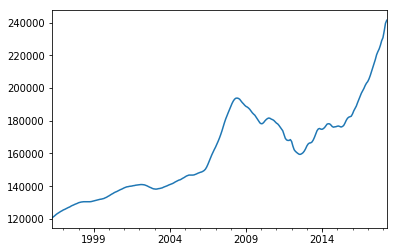

In [15]:
utah_df[84015].plot()

In [16]:
#diving into subsets
#Salt Lake, Utah, Davis, Weber, Washington, Cashe, Tooele, Box Elder, Iron, Summit
utah.CountyName.value_counts()

Salt Lake     35
Utah          19
Cache         12
Davis         10
Washington     9
Weber          7
Box Elder      4
Summit         2
Tooele         2
Iron           2
Name: CountyName, dtype: int64

In [17]:
salt_lake_city = list(utah.loc[(utah.CountyName == 'Salt Lake') & (utah.City == 'Salt Lake City'),'RegionName'])
salt_lake = list(utah.loc[(utah.CountyName == 'Salt Lake') & (utah.City != 'Salt Lake City'),'RegionName'])

utah_c = list(utah.loc[(utah.CountyName == 'Utah'),'RegionName'])
cache = list(utah.loc[(utah.CountyName == 'Cache'),'RegionName'])
davis = list(utah.loc[(utah.CountyName == 'Davis'),'RegionName'])
washington = list(utah.loc[(utah.CountyName == 'Washington'),'RegionName'])
weber = list(utah.loc[(utah.CountyName == 'Weber'),'RegionName'])
box_elder = list(utah.loc[(utah.CountyName == 'Box Elder'),'RegionName'])
iron = list(utah.loc[(utah.CountyName == 'Iron'),'RegionName'])
summit = list(utah.loc[(utah.CountyName == 'Summit'),'RegionName'])
tooele = list(utah.loc[(utah.CountyName == 'Tooele'),'RegionName'])

list_of_subsets = [salt_lake_city, salt_lake, utah_c, cache, davis, washington, weber, box_elder, iron, summit, tooele]
names_of_subsets = ['Salt Lake City - region', 'Salt Lake City - rest of county', 'Utah - county', 'Cache', 'Davis', 'Washington', 'Weber', 'Box Elder', 'Iron', 'Summit', 'Tooele']

d = dict(zip(names_of_subsets,list_of_subsets))


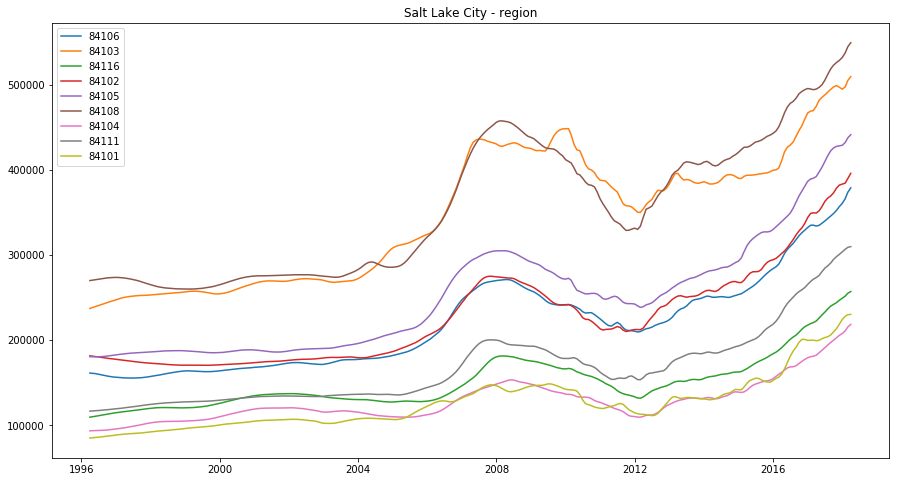

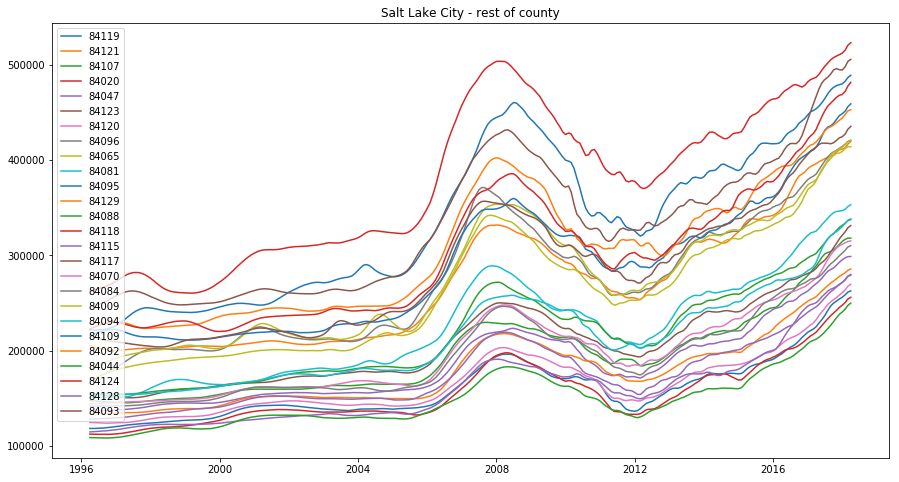

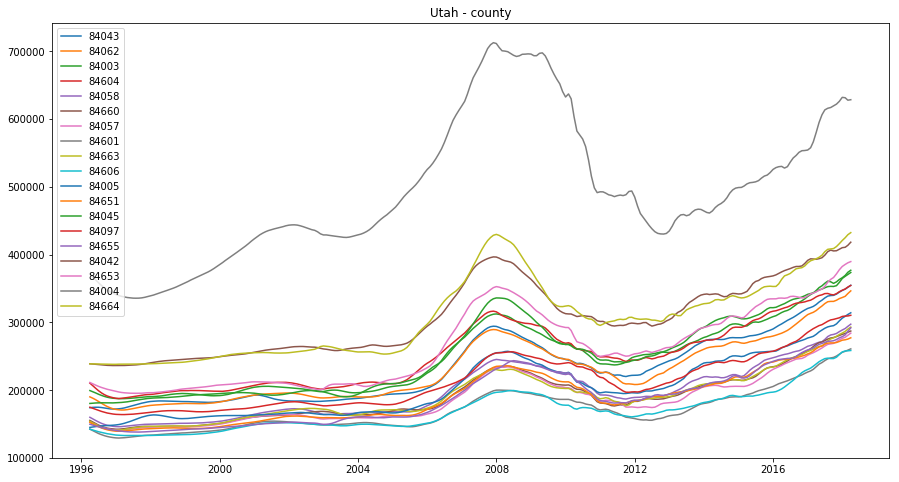

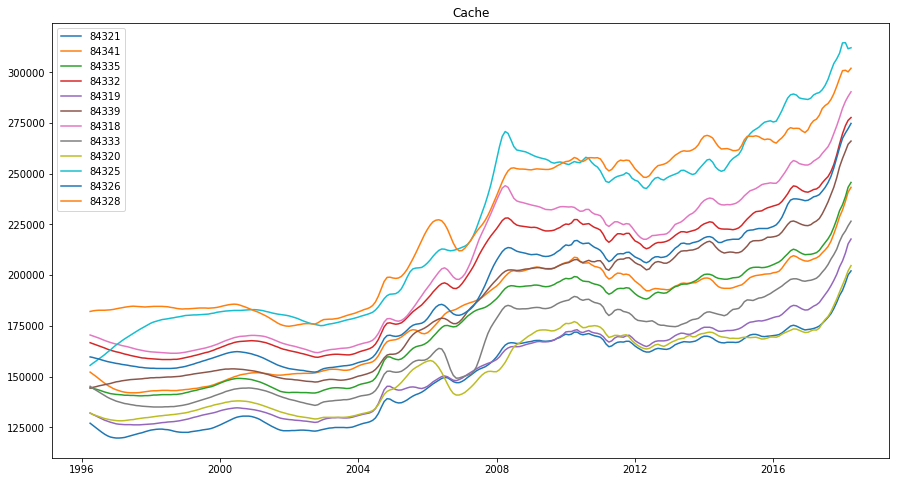

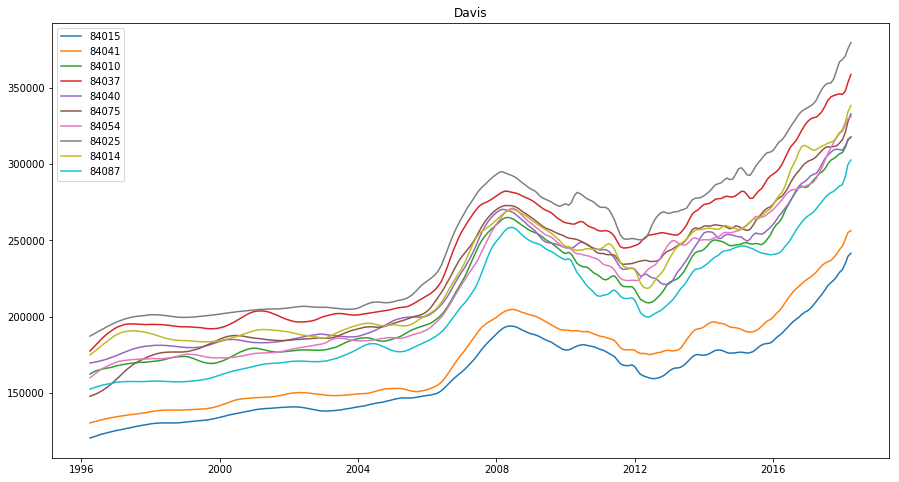

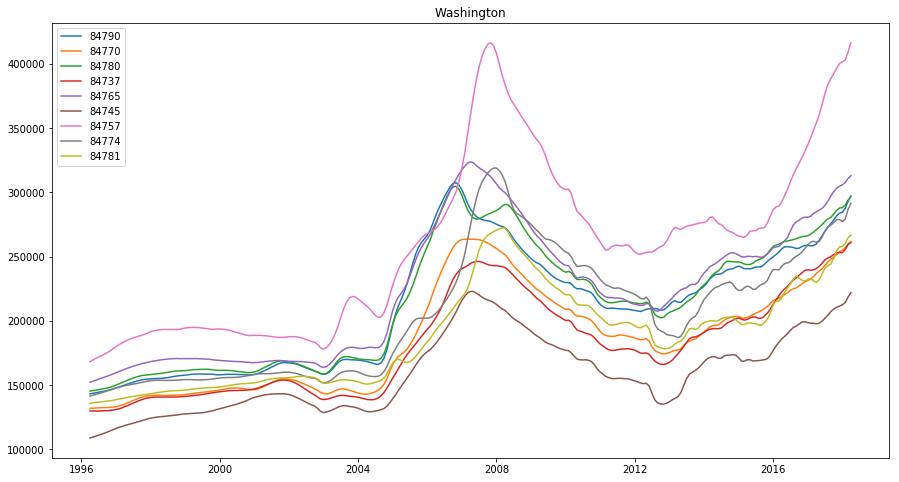

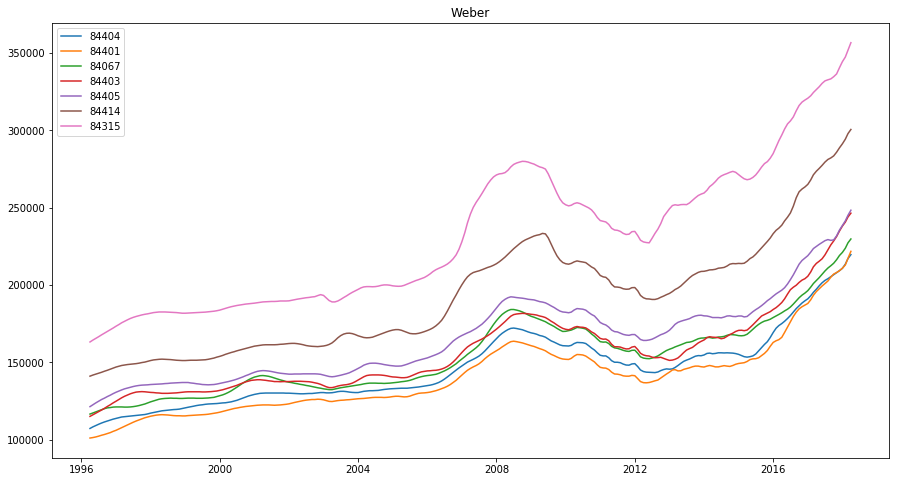

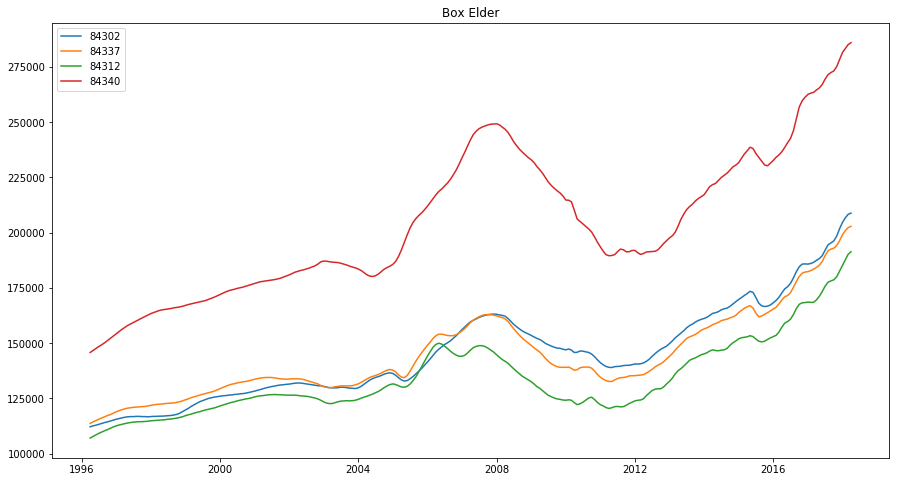

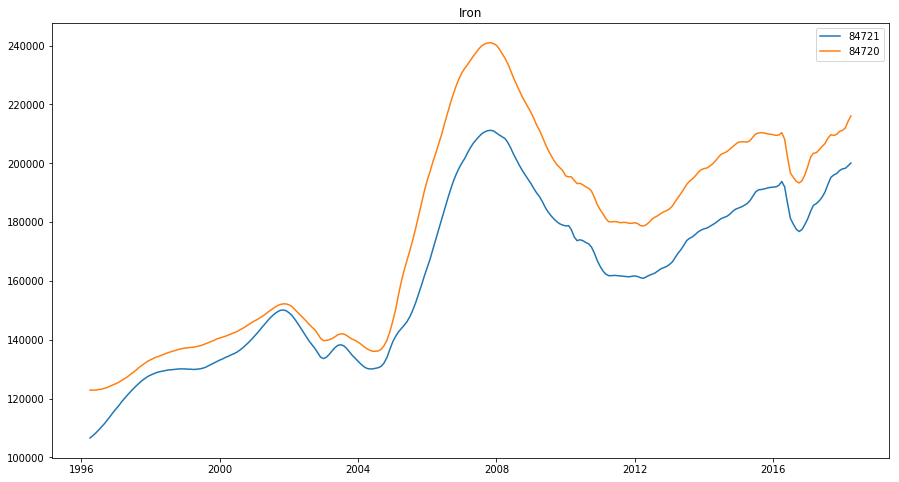

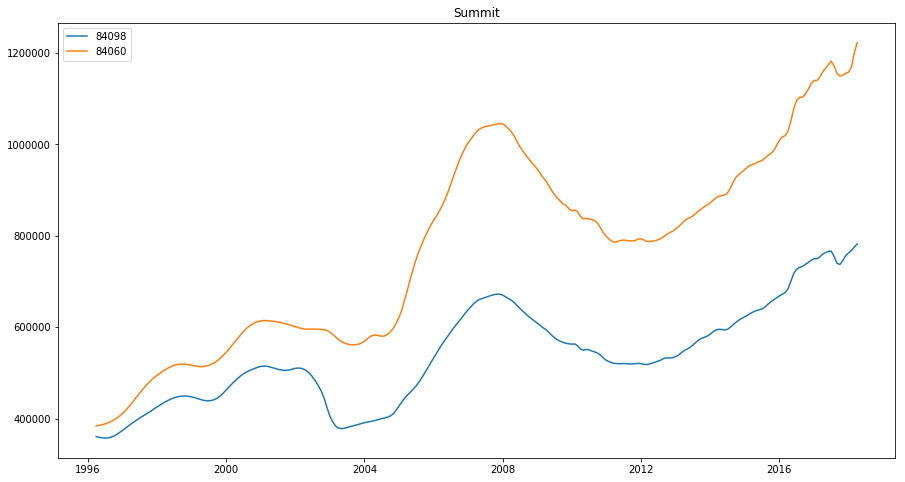

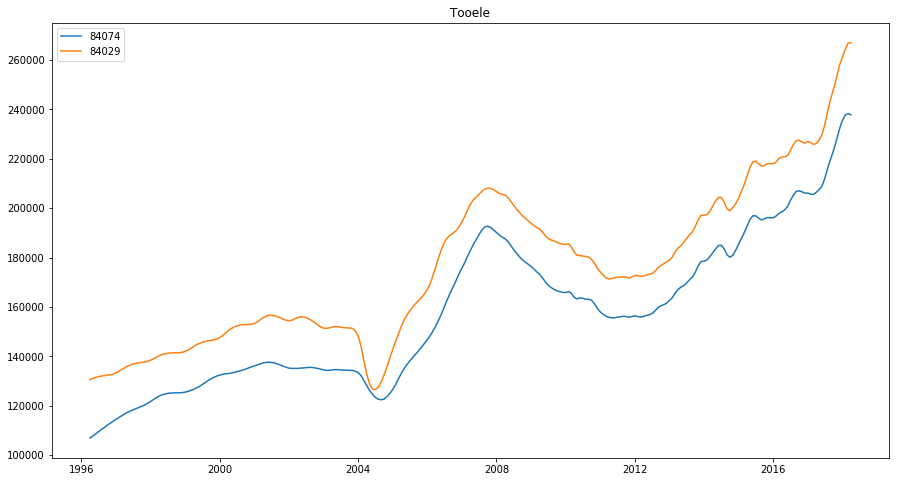

In [17]:

for key,value in d.items():
    fig = plt.figure(figsize=(15,8))
    plt.plot(utah_df[value])
    plt.title(key)
    plt.legend(value)



In [18]:
utah_df.head()

,84404,84015,84043,84041,84119,84790,84770,84074,84121,84010,...,84312,84340,84333,84320,84325,84326,84757,84774,84328,84781
1996-04-01,107200.0,120600.0,174300.0,130500.0,118300.0,143300.0,132000.0,106900.0,205400.0,162500.0,...,107100.0,145800.0,145200.0,132000.0,155500.0,159700.0,168400.0,141600.0,182100.0,135900.0
1996-05-01,108200.0,121200.0,174800.0,131000.0,118200.0,143700.0,132100.0,107700.0,204500.0,163600.0,...,107800.0,146700.0,144200.0,131300.0,156600.0,159400.0,169600.0,142200.0,182400.0,136300.0
1996-06-01,109100.0,121800.0,175000.0,131500.0,118300.0,144100.0,132300.0,108600.0,203500.0,164500.0,...,108500.0,147600.0,143300.0,130800.0,157600.0,159000.0,170800.0,142800.0,182600.0,136600.0
1996-07-01,109900.0,122500.0,175000.0,132000.0,118400.0,144500.0,132400.0,109500.0,202600.0,165100.0,...,109200.0,148500.0,142400.0,130300.0,158700.0,158700.0,171900.0,143400.0,182700.0,136900.0
1996-08-01,110700.0,123100.0,174600.0,132500.0,118600.0,145000.0,132500.0,110400.0,201800.0,165600.0,...,109800.0,149300.0,141500.0,129800.0,159700.0,158200.0,173000.0,144100.0,182700.0,137100.0


In [19]:
#creating new dfs for better viz
#dropping unnecessary colums
to_drop = ['RegionID','RegionName','City','State','Metro','SizeRank']
utah_simple_viz = utah.drop(to_drop, axis=1)
utah_simple_viz.head()

,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
525,Weber,107200.0,108200.0,109100.0,109900.0,110700.0,111400.0,112000.0,112600.0,113200.0,...,202900,204000,205300,206500,207800,209200,210700,213400,217000,219600
637,Davis,120600.0,121200.0,121800.0,122500.0,123100.0,123600.0,124100.0,124600.0,125000.0,...,217500,220400,222300,223900,226200,229000,230800,234900,239600,241500
1088,Utah,174300.0,174800.0,175000.0,175000.0,174600.0,173900.0,173300.0,172600.0,172400.0,...,336200,338900,339700,340000,341900,344700,347300,349200,351900,354900
1231,Davis,130500.0,131000.0,131500.0,132000.0,132500.0,133000.0,133400.0,133800.0,134100.0,...,235100,236000,236800,238600,241000,243900,246200,250700,255200,256300
1419,Salt Lake,118300.0,118200.0,118300.0,118400.0,118600.0,118800.0,119200.0,119500.0,119800.0,...,236800,242100,246900,249800,251900,254100,256000,258600,261400,262700


In [20]:
#calculate benchmark - average 
utah_simple_viz['mean'] = utah_simple_viz.mean(axis=1)
mean = utah_simple_viz.mean()

In [21]:
utah_simple_viz.drop('mean', axis=1,inplace=True)

In [22]:
utah_simple_viz.head()

,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
525,Weber,107200.0,108200.0,109100.0,109900.0,110700.0,111400.0,112000.0,112600.0,113200.0,...,202900,204000,205300,206500,207800,209200,210700,213400,217000,219600
637,Davis,120600.0,121200.0,121800.0,122500.0,123100.0,123600.0,124100.0,124600.0,125000.0,...,217500,220400,222300,223900,226200,229000,230800,234900,239600,241500
1088,Utah,174300.0,174800.0,175000.0,175000.0,174600.0,173900.0,173300.0,172600.0,172400.0,...,336200,338900,339700,340000,341900,344700,347300,349200,351900,354900
1231,Davis,130500.0,131000.0,131500.0,132000.0,132500.0,133000.0,133400.0,133800.0,134100.0,...,235100,236000,236800,238600,241000,243900,246200,250700,255200,256300
1419,Salt Lake,118300.0,118200.0,118300.0,118400.0,118600.0,118800.0,119200.0,119500.0,119800.0,...,236800,242100,246900,249800,251900,254100,256000,258600,261400,262700


In [23]:
counties = list(utah_simple_viz.CountyName.unique())

weber = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[0]]
davis = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[1]]
utah_c = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[2]]
salt_lake = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[3]]
washington = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[4]]
tooele = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[5]]
cache = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[6]]
box_elder = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[7]]
summit = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[8]]
iron = utah_simple_viz.loc[utah_simple_viz.CountyName == counties[9]]

counties_df = [weber, davis, utah_c, salt_lake, washington, tooele, cache, box_elder, summit, iron]



In [24]:
#dropping CountyName columns from dfs
for dataframe in counties_df:
    dataframe = dataframe.drop('CountyName', axis=1, inplace=True)

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [25]:
#testing
weber = weber.T
davis = davis.T

In [26]:
#renaming columns
weber.rename(columns=zipcode_dict,inplace=True)
davis.rename(columns=zipcode_dict,inplace=True)



In [27]:
to_plot = [weber, davis]
to_plot_names = ['weber', 'davis']

In [46]:
weber.head()

,84404,84401,84067,84403,84405,84414,84315
1996-04,107200.0,101000.0,116500.0,115000.0,121300.0,141000.0,163100.0
1996-05,108200.0,101300.0,117200.0,116000.0,122500.0,141700.0,164300.0
1996-06,109100.0,101700.0,117900.0,117000.0,123700.0,142300.0,165400.0
1996-07,109900.0,102200.0,118700.0,118000.0,124800.0,142900.0,166500.0
1996-08,110700.0,102800.0,119400.0,119100.0,125900.0,143500.0,167700.0


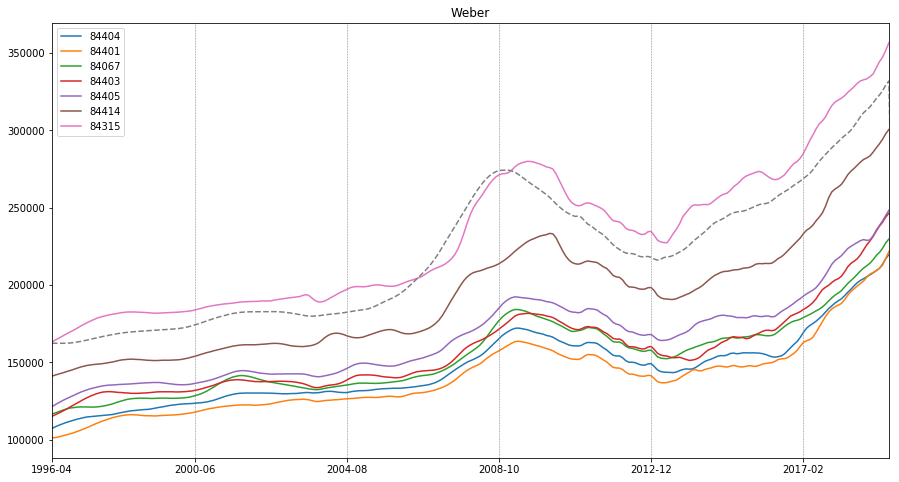

In [85]:
to_plot[0].plot(figsize=(15,8))

plt.plot(mean, color='grey', linestyle='dashed')
plt.title(str(to_plot_names[0]).title())

#plt.tick_params(axis ='x', rotation = 75,color='yellow',labelcolor='yellow') 

plt.xticks(['1996-04','2000-01','2004-01','2008-01','2012-01','2016-01']) 

plt.axvline('2000-01', color='grey', linestyle='--', lw=0.5)
plt.axvline('2004-01', color='grey', linestyle='--', lw=0.5)
plt.axvline('2008-01', color='grey', linestyle='--', lw=0.5)
plt.axvline('2012-01', color='grey', linestyle='--', lw=0.5)
plt.axvline('2016-01', color='grey', linestyle='--', lw=0.5)



plt.show()

## commentary

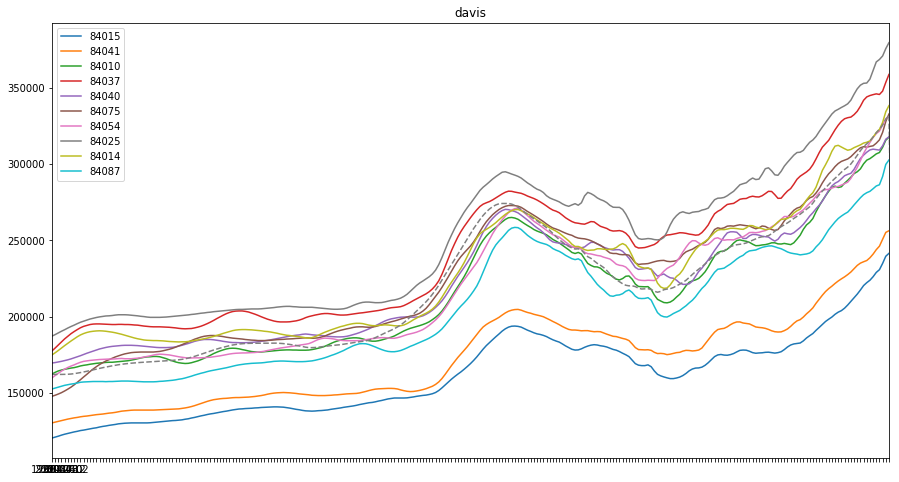

In [122]:
to_plot[1].plot(figsize=(15,8))
plt.plot(mean, color='grey', linestyle='dashed')
plt.title(str(to_plot_names[1]));

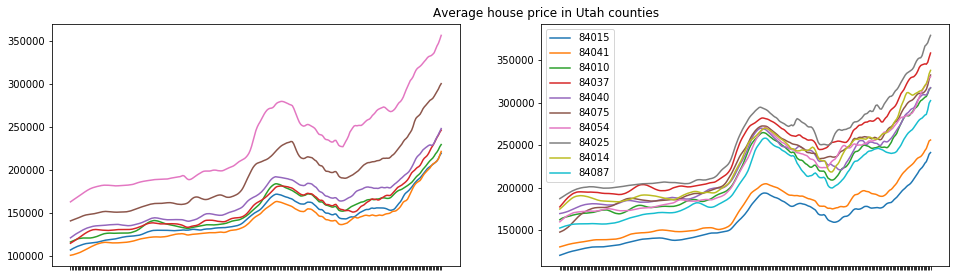

In [62]:
to_plot = [weber, davis]
to_plot_names = ['weber', 'davis']

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,4),sharex=True)
fig.subplots_adjust(top=0.92, bottom=0.08, left=0.01, right=0.9, hspace=0.25,wspace=0.2)
fig.suptitle('Average house price in Utah counties')

for ax, feature, name in zip(axes.flatten(), to_plot, to_plot_names):

    ax.plot(feature)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    plt.legend(feature)

    


# Step 3: EDA and Visualization

In [25]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

NameError: name 'matplotlib' is not defined

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

# Step 6: Interpreting Results